# Santander Value Prediction Challenge:  EDA + Baseline Model

## 1. Introduction
According to Epsilon research, 80% of customers are more likely to do business with you if you provide personalized service. Banking is no exception.

The digitalization of everyday lives means that customers expect services to be delivered in a personalized and timely manner… and often before they´ve even realized they need the service. In their 3rd Kaggle competition, Santander Group aims to go a step beyond recognizing that there is a need to provide a customer a financial service and intends to determine the amount or value of the customer's transaction. This means anticipating customer needs in a more concrete, but also simple and personal way. With so many choices for financial services, this need is greater now than ever before.

In this competition, Santander Group is asking Kagglers to help them identify the value of transactions for each potential customer. This is a first step that Santander needs to nail in order to personalize their services at scale.

## 2. Data Laoding and Simple EDA

In [1]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

Train shape:  (4459, 4993)
Test shape:  (49342, 4992)


In [3]:
train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


We observe that column names are anonymized, which means we may not rely on any domain knowledge. Also, this is a sparse tabular dataset since there are lots of zero values. 

## 2.1 Target variable
First, let's start with the target variable. Draw a scatter plot of the target variable to see if there are any visible outliers.

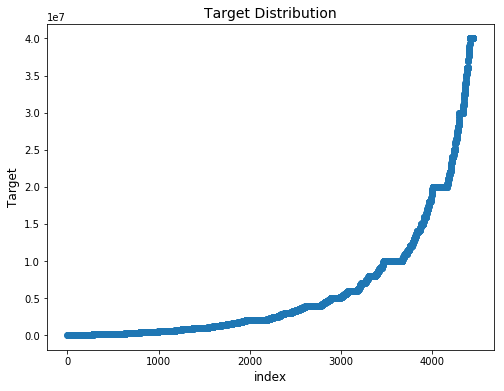

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train['target'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title("Target Distribution", fontsize=14)
plt.show()

It seems like there is no obvious outlier in the data, but the range of the target variable is enormous. Let's take a look at its histogram. 

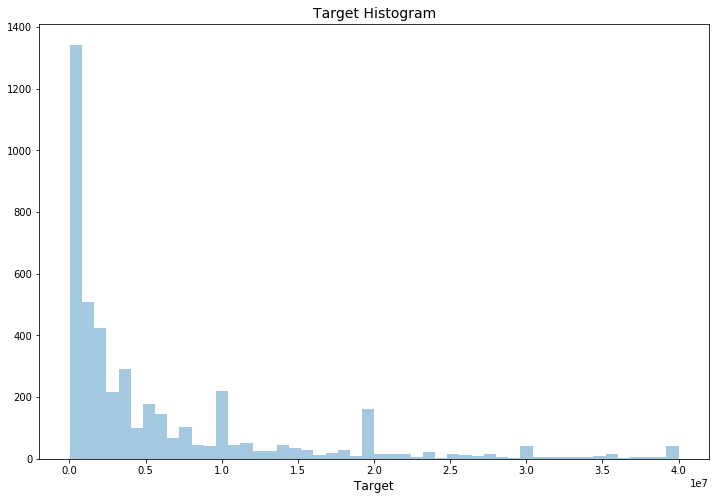

In [5]:
plt.figure(figsize=(12,8))
sns.distplot(train["target"].values, bins=50, kde=False)
plt.xlabel('Target', fontsize=12)
plt.title("Target Histogram", fontsize=14)
plt.show()

From the hisogram plot, we find the target variable has a right skewed distritbuion that the magority of data poits locate at small values. That is why the competition organizer chooses RMSLE as the evaluation metric. So let's check distribuion of the log of target variable.

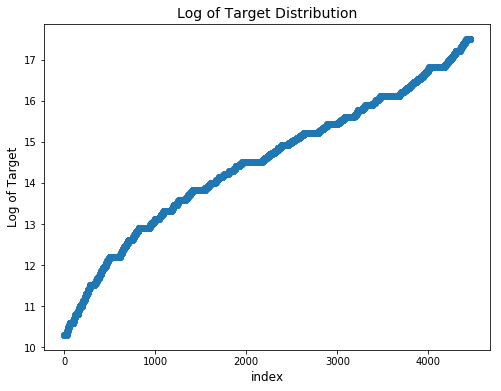

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(np.log1p(train['target'].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('Log of Target', fontsize=12)
plt.title("Log of Target Distribution", fontsize=14)
plt.show()

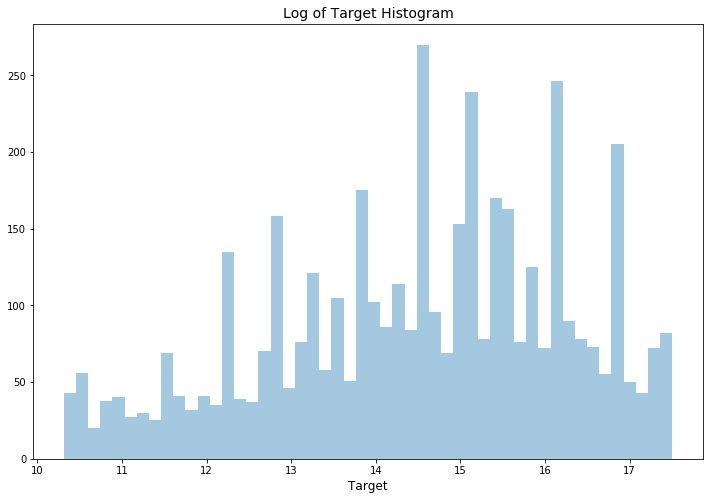

In [7]:
plt.figure(figsize=(12,8))
sns.distplot( np.log1p(train["target"].values), bins=50, kde=False)
plt.xlabel('Target', fontsize=12)
plt.title("Log of Target Histogram", fontsize=14)
plt.show()

## 2.2  Anonymised features
We know that dataset has 4491 anonymised features, let's check if there are any __missing values__ in it.

In [8]:
missing = train.isnull().sum(axis=0).reset_index()
missing.columns = ['column_name', 'missing_count']
missing = missing[missing['missing_count']>0]
missing = missing.sort_values(by='missing_count')
missing

,column_name,missing_count


There is no missing value in the train set. Let's then check __data types__ of features. 

In [9]:
dtype_df = train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,3147
1,float64,1845
2,object,1


We can find that most of the columns are of integer type and the rest are float type. There is only one objct column which is the 'ID' column.

__Constant features__ can lead to errors in some models and obviously provide no information in the training set that can be learned from. So the next step is to check and remove constant columns.

In [10]:
feats_counts = train.nunique(dropna = False)    
constant_features = feats_counts.loc[feats_counts==1].index.tolist()

print('There are %d constant features' % len(constant_features))
print (constant_features)

train.drop(constant_features, axis = 1, inplace=True)
test.drop(constant_features, axis = 1, inplace=True)

There are 256 constant features
['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee', '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca', '7ac332a1d', '70ee7950a', '833b35a7c', '2f9969eab', '8b1372217', '68322788b', '2288ac1a6', 'dc7f76962', '467044c26', '39ebfbfd9', '9a5ff8c23', 'f6fac27c8', '664e2800e', 'ae28689a2', 'd87dcac58', '4065efbb6', 'f944d9d43', 'c2c4491d5', 'a4346e2e2', '1af366d4f', 'cfff5b7c8', 'da215e99e', '5acd26139', '9be9c6cef', '1210d0271', '21b0a54cb', 'da35e792b', '754c502dd', '0b346adbd', '0f196b049', 'b603ed95d', '2a50e001c', '1e81432e7', '10350ea43', '3c7c7e24c', '7585fce2a', '64d036163', 'f25d9935c', 'd98484125', '95c85e227', '9a5273600', '746cdb817', '6377a6293', '7d944fb0c', '87eb21c50', '5ea313a8c', '0987a65a1', '2fb7c2443', 'f5dde409b', '1ae50d4c3', '2b21cd7d8', '0db8a9272', '804d8b55b', '76f135fa6', '7d7182143', 'f88e61ae6', '378ed28e0', 'ca4ba131e', '1352ddae5', '2b601ad67', '6e42ff7c7', '22196a84c', '0e410eb3d', '992e6d1d3', '90a7

We are usually interested in __correlations of features with the target variable__. The problem is which correleation should we use: "Pearson" or "Spearman"? 
The difference is that Pearson’s method is looking for linear relationships whereas Spearman tests for simply monotonic ones (by comparing the ranks of the columns). In our case since the target distribution is heavily skewed, linear relationships may not be a good choice thus we prefer __Spearman Correlation__. 

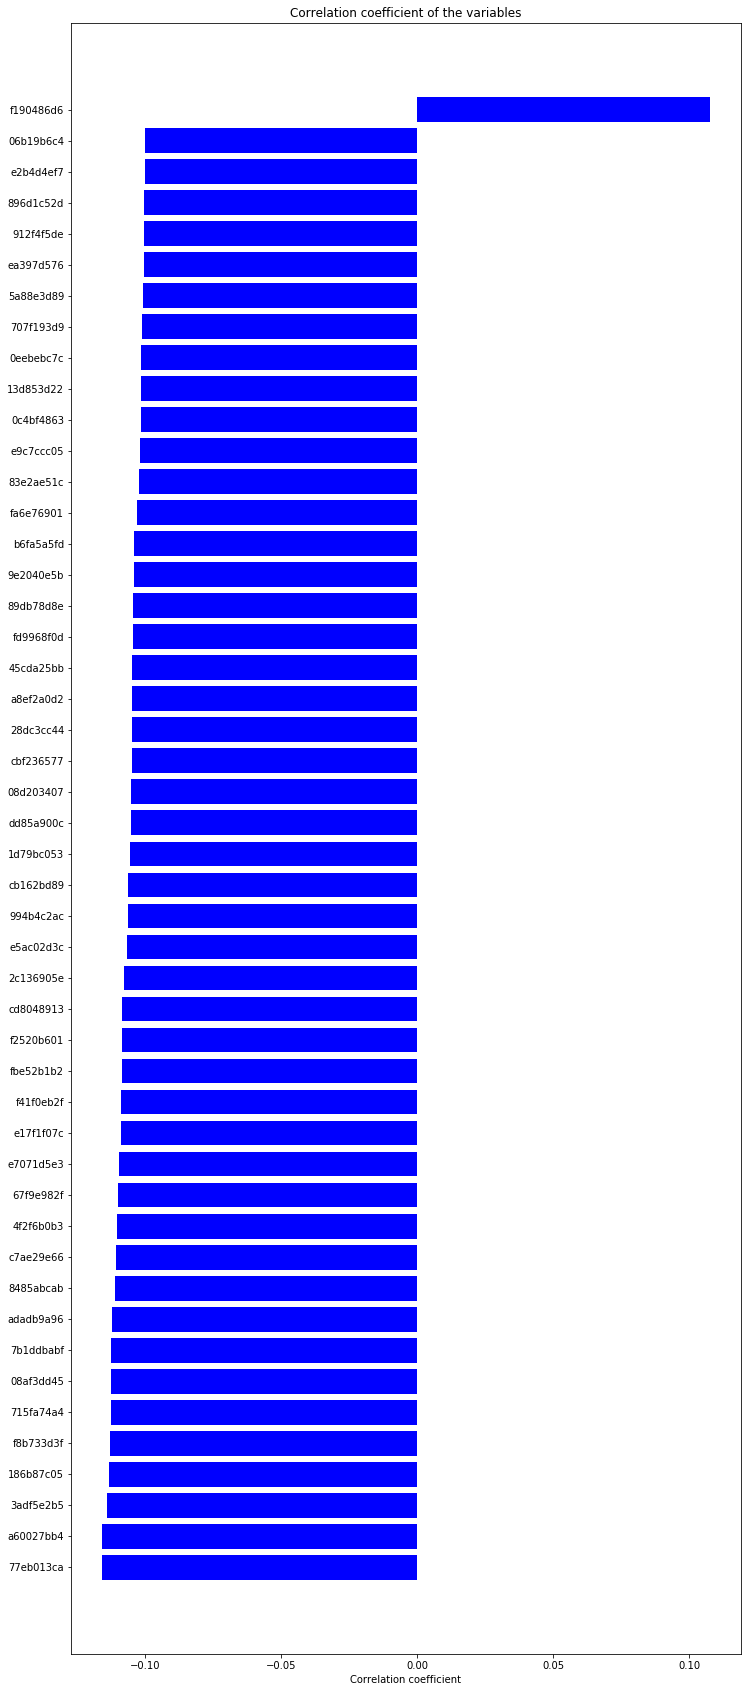

In [11]:
from scipy.stats import spearmanr

labels = []
values = []
for col in train.columns:
    if col not in ["ID", "target"]:
        labels.append(col)
        values.append(spearmanr(train[col].values, train["target"].values)[0])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
 
corr_df = corr_df[(corr_df['corr_values']>0.1) | (corr_df['corr_values']<-0.1)]
ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,30))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

We can select important features by setting a threshold of correlation absolute value (like 0.11) and draw a correlation heat map.
This process can identify if there are any strong monotonic relationships between these important features. The higher the values are, the more probably we will keep these variables in the model building process. 

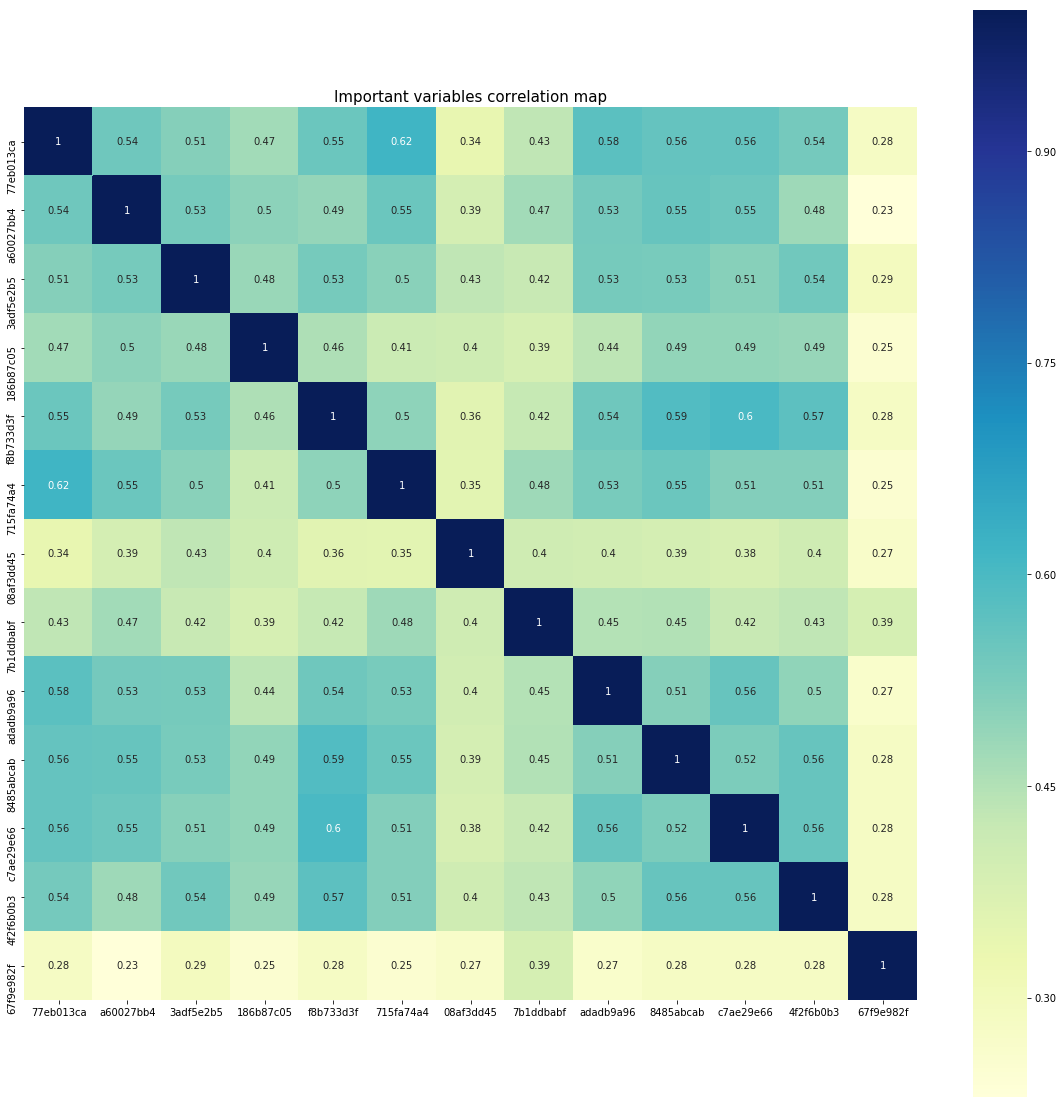

In [12]:
cols_to_use = corr_df[(corr_df['corr_values']>0.11) | (corr_df['corr_values']<-0.11)].col_labels.tolist()

temp_df = train[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(corrmat, vmax=1., cmap="YlGnBu", annot=True, square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

We observe some moderately strong correlations but none of them are greater than 0.7. We can get feature importance further with Extra Tree model. 

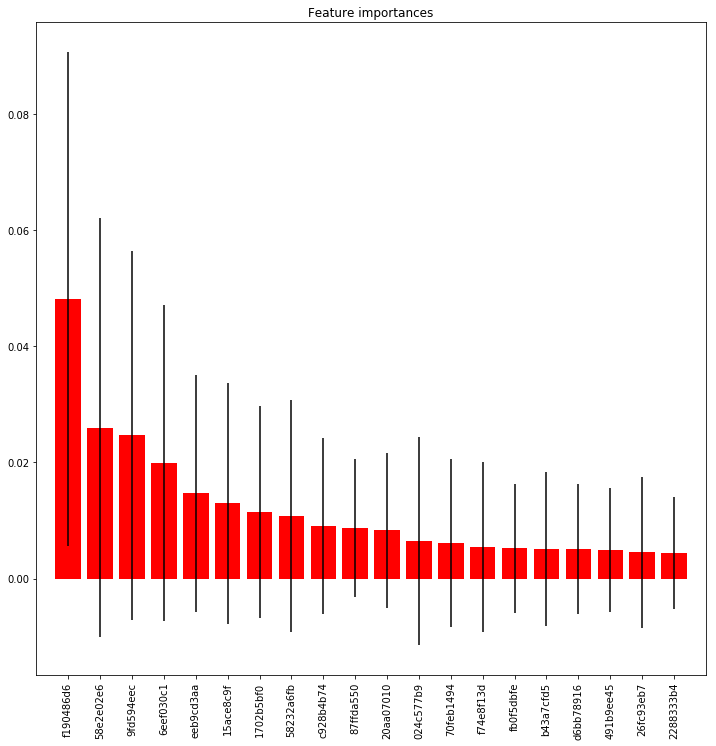

In [13]:
train_X = train.drop(["ID", "target"], axis=1)
test_X = test.drop(["ID"], axis=1)
train_y = np.log1p(train["target"].values)

from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

## plot the importances ##
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

## 3. Model building
### 3.1 LightGBM 

In [14]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=200, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [15]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44231
[400]	valid_0's rmse: 1.42178
Early stopping, best iteration is:
[380]	valid_0's rmse: 1.42093
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44249
[400]	valid_0's rmse: 1.40968
[600]	valid_0's rmse: 1.40662
Early stopping, best iteration is:
[532]	valid_0's rmse: 1.40543
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44369
[400]	valid_0's rmse: 1.41905
Early stopping, best iteration is:
[479]	valid_0's rmse: 1.41808
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.49096
[400]	valid_0's rmse: 1.45485
[600]	valid_0's rmse: 1.44857
[800]	valid_0's rmse: 1.44774
[1000]	valid_0's rmse: 1.44622
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 1.44611
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.48257
[400]	valid_0's rmse:

This model scored 1.47 RMSLE on the public set. Since this is just a baseline model, we does not do any feature selection, feature engineering and hyperparameter tuning.

In [16]:
#Creating a submission file
sub_df = pd.DataFrame({"ID":test["ID"].values})
sub_df["target"] = pred_test_full
sub_df.to_csv("baseline_lgb.csv", index=False)

A benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model. So let's plot feature importance caculated by our LightGBM model.

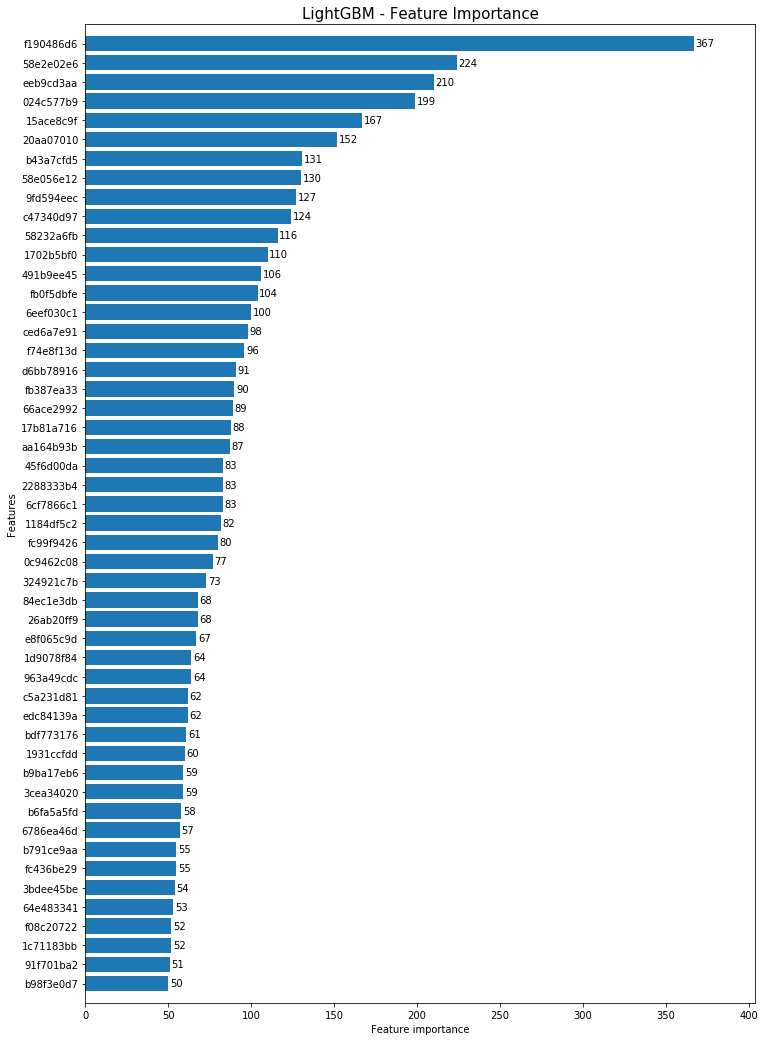

In [17]:
#Feature Importance
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

We find that the top two important features are same as that of the Extra trees model. We could then do some kind of feature selection using these feature importances and improve our models further.

### 3.2 XGBoost 

In [22]:
def run_xgb(train_X, train_y, val_X, val_y, test_X):
    params = {
          'objective': 'reg:linear', 
          'eval_metric': 'rmse',
          'eta': 0.01,
          'max_depth': 10, 
          'subsample': 0.7, 
          'colsample_bytree': 0.7,
          'alpha':0.001,
          'random_state': 42, 
          'silent': True}
    
    xgbtr = xgb.DMatrix(train_X, train_y)
    xgbval = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(xgbtr, 'train'), (xgbval, 'valid')]
    
    model_xgb = xgb.train(params, xgbtr, 1000, watchlist, maximize=False, early_stopping_rounds = 100, verbose_eval=200)
    
    dtest = xgb.DMatrix(test_X)
    xgb_pred_y = np.expm1(model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit))
    
    return xgb_pred_y, model_xgb

In [23]:
pred_test_full = 0
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_test_xgb, model_xgb = run_xgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test_xgb
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

[0]	train-rmse:13.9443	valid-rmse:14.0267
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[200]	train-rmse:2.27685	valid-rmse:2.4402
[400]	train-rmse:1.06373	valid-rmse:1.46711
[600]	train-rmse:0.921008	valid-rmse:1.42981
[800]	train-rmse:0.850929	valid-rmse:1.42779
Stopping. Best iteration:
[785]	train-rmse:0.855788	valid-rmse:1.42726

[0]	train-rmse:13.9691	valid-rmse:13.9269
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[200]	train-rmse:2.28085	valid-rmse:2.38218
[400]	train-rmse:1.06416	valid-rmse:1.45977
[600]	train-rmse:0.924637	valid-rmse:1.42776
[800]	train-rmse:0.848983	valid-rmse:1.42287
[999]	train-rmse:0.794744	valid-rmse:1.41922
[0]	train-rmse:13.9556	valid-rmse:13.9801
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-

In [24]:
#Creating a submission file
sub_df = pd.DataFrame({"ID":test["ID"].values})
sub_df["target"] = pred_test_full
sub_df.to_csv("baseline_xgb.csv", index=False)

### 3.3 Catboost

In [27]:
cb_model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.01,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 200,
                             od_wait=20)

In [28]:
pred_test_full = 0
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    cb_model.fit(dev_X, dev_y,
                 eval_set=(val_X, val_y),
                 use_best_model=True,
                 verbose=True)
    
    pred_test_cat = np.expm1(cb_model.predict(test_X))
    pred_test_full += pred_test_cat
pred_test_full /= 5.

0:	learn: 14.4373614	test: 14.5210607	best: 14.5210607 (0)	total: 6.11s	remaining: 1h 41m 47s
200:	learn: 2.6224780	test: 2.6798866	best: 2.6798866 (200)	total: 17m 45s	remaining: 1h 10m 35s
400:	learn: 1.6625031	test: 1.6475126	best: 1.6475126 (400)	total: 35m 19s	remaining: 52m 45s
600:	learn: 1.5748980	test: 1.5683749	best: 1.5683749 (600)	total: 52m 45s	remaining: 35m 1s
800:	learn: 1.5449691	test: 1.5524487	best: 1.5524487 (800)	total: 1h 10m 11s	remaining: 17m 26s
999:	learn: 1.5079832	test: 1.5382038	best: 1.5382038 (999)	total: 1h 27m 28s	remaining: 0us

bestTest = 1.538203846
bestIteration = 999

Shrink model to first 1000 iterations.
0:	learn: 14.4610469	test: 14.4187972	best: 14.4187972 (0)	total: 5.53s	remaining: 1h 32m 3s
200:	learn: 2.6138901	test: 2.5999235	best: 2.5999235 (200)	total: 17m 51s	remaining: 1h 11m
400:	learn: 1.6534348	test: 1.6797540	best: 1.6797540 (400)	total: 35m 38s	remaining: 53m 15s
600:	learn: 1.5767354	test: 1.6150417	best: 1.6150417 (600)	total: 5

In [29]:
#Creating a submission file
sub_df = pd.DataFrame({"ID":test["ID"].values})
sub_df["target"] = pred_test_full
sub_df.to_csv("baseline_cb.csv", index=False)

## 4. Conclusion
LightGBM and XGBoost models have similar RMSLE scores (around 1.47), while Catboost has a little bit more errors. And LightGBM runs much faster than the other two models, which is a great advantage. In the futuer, we will do feature selection, feature engineering and hyperparameter tuning to improve the performance of our models.